<a href="https://colab.research.google.com/github/UN-GCPDS/python-gcpds.EEG_Tensorflow_models/blob/main/Examples/BCI2a/shallowconvnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BCI2a

In [2]:
from EEG_Tensorflow_models.Utils.LoadData import load_dataset,get_classes,get_data_from_BaseConcatDataset
from EEG_Tensorflow_models.Utils.Callbacks import get_callbacks
from EEG_Tensorflow_models.Utils.TrainingModels import get_loss,get_model,get_optimizer,train_model_cv
import tensorflow as tf
from EEG_Tensorflow_models.Utils.Attention_maps import Attention_maps

In [3]:
import numpy as np
import pickle
from scipy.signal import resample
import functools
import json

# Exp 1: Schirmeister 2017

In [ ]:
with tf.device('/cpu:0'):
    opt_args = {'lr': 0.01,'beta_1': 0.9}
    optimizer = get_optimizer('Adam',opt_args)

    loss = get_loss('CategoricalCrossentropy')

    metrics = ['accuracy']

    callbacks_names = {'early_stopping_train':'early_stopping','checkpoint_train':'checkpoint',
                    'Threshold_valid':'Threshold','checkpoint_valid':'checkpoint',
                    'early_stopping_valid':'early_stopping'}


    Experiment = 'schirrmeister2017'
    model_name = 'ShallowConvNet'
    Version='2018'

    subjects = np.arange(1,10)
    Acc = []
    History = []
    Subject = []
    new_fs = 128.0
    for sbj in [8]:#subjects:
        print('Subject: {:d} of {:d}'.format(sbj,len(subjects)))

        classes = ["left_hand", "right_hand"]#["feet", "left_hand", "right_hand", "tongue"]
        windows_dataset = load_dataset(dataset_name="BNCI2014001", subject_id=sbj)
        sessions = windows_dataset.split('session')
        train_set = sessions['session_T']
        valid_set = sessions['session_E']
        X_train, y_train = get_data_from_BaseConcatDataset(train_set)
        X_valid, y_valid = get_data_from_BaseConcatDataset(valid_set)

        mapping_classes = train_set.datasets[0].windows.event_id
        if len(classes) != len(mapping_classes):
            classes_id = [mapping_classes[cls] for cls in classes]
            X_train, y_train = get_classes(X_train, y_train, classes_id)
            X_valid, y_valid = get_classes(X_valid, y_valid, classes_id)
        info = windows_dataset.datasets[0].windows.info

        #It is generally recommended not to epoch downsampled data,
        #but instead epoch and then downsample, as epoching
        #downsampled data jitters triggers. -> mne.io.Raw.resample()
        if new_fs == info["sfreq"]:
            print('No resampling, since new sampling rate same.')
        else:
            print("Resampling from {:f} to {:f} Hz.".format(info["sfreq"], new_fs))
            X_train = resample(X_train,int((X_train.shape[-2]/info["sfreq"])*new_fs),axis=-2)    
            X_valid = resample(X_valid,int((X_valid.shape[-2]/info["sfreq"])*new_fs),axis=-2)    
            info['sfreq'] = new_fs   
        

        model_args = {'nb_classes':2,'Chans':X_train.shape[1],'Samples':X_train.shape[2],'dropoutRate':0.5,'version':Version}
        model = get_model(model_name,model_args)
        

        #model_args = {'nb_classes':4,'Chans':X_train.shape[1],'Samples':X_train.shape[2],'dropoutRate':0.5,'version':'2017'}
        #model = get_model(model_name,model_args)
        
        call_args = [{'monitor':'val_accuracy','patience':100,'min_delta':0.001,'mode':'max','verbose':1,'restore_best_weights':False},
                    {'filepath':'./tmp/checkpoint_sbj_'+str(sbj)+'_cls_'+str(len(classes)),'save_format':'tf','monitor':'val_accuracy','verbose':1,'save_weights_only':False,'save_best_only':True},
                    {'threshold':None},
                    {'filepath':'./tmp/checkpoint_2_sbj_'+str(sbj)+'_cls_'+str(len(classes)),'save_format':'tf','monitor':'val_accuracy','verbose':1,'save_weights_only':False,'save_best_only':True},
                    {'monitor':'val_accuracy','patience':None,'min_delta':0.001,'mode':'max','verbose':1,'restore_best_weights':True}]
                    
        callbacks = get_callbacks(callbacks_names,call_args)

        cv = train_model_cv(model,optimizer,loss,metrics,callbacks=callbacks)

        history = cv.fit_validation(X_train,y_train,X_val=X_valid,y_val=y_valid,batch_size=64,epochs=1000,verbose=0,val_mode=Experiment)
        acc = cv.get_accuracy()
        print('Subject accuracy: {:f}'.format(acc))
        Acc.append(acc)
        History.append(history)
        Subject.append(sbj)

        results = {}
        results['subject'] = Subject
        results['history'] = History
        results['accuracy'] = Acc

        with open('Results_BCI2a_'+Experiment+'_'+model_name+Version+'_cls_'+str(len(classes))+'.p','wb') as handle:
            pickle.dump(results,handle)
        
        #del cv,callbacks,X_train,y_train,X_valid,y_valid,fs

In [45]:
# perform arctivation class over all subjects
def Confidence_index(model,x_train,y_train,tmpr):
    y_tilde=[]
    y=[]
    labels=[]
    for i in np.unique(y_train):
        idx = y_train==i
        labels.append(y_train[idx])
        x = x_train[idx]
        y_tilde.append(model.predict(x*tmpr[0,i,:,:,np.newaxis]))
        y.append(model.predict(x))
    y_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),y)
    labels_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),labels)
    y_tilde_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),y_tilde)
    result=[]
    for j in range(len(y_all)):
        if np.argmax(y_tilde_all[j])!=labels_all[j]:
            result.append(-1)
        elif y_tilde_all[j][labels_all[j]]>y_all[j][labels_all[j]]:
            result.append(1)
        else:
            result.append(0) 
    return result
# perform arctivation class over all subjects
def Confidence_index_2(model,x_train,y_train,relM):
    y_tilde=[]
    y=[]
    labels=[]
    for i in np.unique(y_train):
        idx = y_train==i
        labels.append(y_train[idx])
        x = x_train[idx]
        y_tilde.append(model.predict(x*relM[0,i,:,:,:,np.newaxis]))
        y.append(model.predict(x))
    y_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),y)
    labels_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),labels)
    y_tilde_all = functools.reduce(lambda x,y:np.concatenate([x,y],axis=0),y_tilde)
    result=[]
    for j in range(len(y_all)):
        if np.argmax(y_tilde_all[j])!=labels_all[j]:
            result.append(-1)
        elif y_tilde_all[j][labels_all[j]]>y_all[j][labels_all[j]]:
            result.append(1)
        else:
            result.append(0) 
    return result

In [ ]:
subjects = np.arange(1,10)
new_fs = 128
with tf.device('/cpu:0'):
    for sbj in [8]:#,2,3,4,5,6,7,8,9]:
        print('Subject: {:d} of {:d}'.format(sbj,len(subjects)))
        classes = ["left_hand", "right_hand"]#["feet", "left_hand", "right_hand", "tongue"]
        windows_dataset = load_dataset(dataset_name="BNCI2014001", subject_id=sbj)
        sessions = windows_dataset.split('session')
        train_set = sessions['session_T']
        valid_set = sessions['session_E']
        X_train, y_train = get_data_from_BaseConcatDataset(train_set)
        #X_valid, y_valid = get_data_from_BaseConcatDataset(valid_set)

        mapping_classes = train_set.datasets[0].windows.event_id
        if len(classes) != len(mapping_classes):
            classes_id = [mapping_classes[cls] for cls in classes]
            X_train, y_train = get_classes(X_train, y_train, classes_id)
            #X_valid, y_valid = get_classes(X_valid, y_valid, classes_id)
        info = windows_dataset.datasets[0].windows.info
        y_train=y_train.astype(int)

        #It is generally recommended not to epoch downsampled data,
        #but instead epoch and then downsample, as epoching
        #downsampled data jitters triggers. -> mne.io.Raw.resample()
        if new_fs == info["sfreq"]:
            print('No resampling, since new sampling rate same.')
        else:
            print("Resampling from {:f} to {:f} Hz.".format(info["sfreq"], new_fs))
            X_train = resample(X_train,int((X_train.shape[-2]/info["sfreq"])*new_fs),axis=-2)    
            #X_valid = resample(X_valid,int((X_valid.shape[-2]/info["sfreq"])*new_fs),axis=-2)    
            info['sfreq'] = new_fs   
        
        model = tf.keras.models.load_model(f'/home/daniel/Documents/python-gcpds.EEG_Tensorflow_models/Examples/BCI2a/tmp/checkpoint_2_sbj_{sbj}_cls_2') #
        #checkpoint_2_sbj_'+str(sbj)+'_cls_'+str(len(classes))
        ## falta agregar aqui como cargar Xraw y cargar el modelo que es con el _cls_2 par ael caso izq derecha.. y hacer el confidence
        # using cpu if needed.

        rel_model_name = ['Gradcam++'] #Gradcam, Gradcam++, Saliency, Scorecam
        layer_name =  ['Conv2D_1','Conv2D_2'] #'conv\w*\s' ---errors, check...
        relM_,tmpr_ = Attention_maps(rel_model_name,layer_name,model,
                                            X_train,y_train,function_combination=np.prod,
                                            norm_c=False,norm_max_min=False,
                                            plot_int=False,transpose=False)
        new_model = tf.keras.Model(inputs=model.input,outputs=model.get_layer('output').output)
        tmpr_=tmpr_/(1e-8+tmpr_.max())
        result = {'result_tmpr':Confidence_index(model,X_train,y_train,tmpr_),
                'result_relM': Confidence_index_2(model,X_train,y_train,relM_)}
        with open(f'/home/daniel/Documents/python-gcpds.EEG_Tensorflow_models/Examples/BCI2a/tmp/confidence{sbj}_cls_2.json','w') as f:
            json.dump(result,f)
        print(f'saved subjetc {sbj}')

<AxesSubplot:>

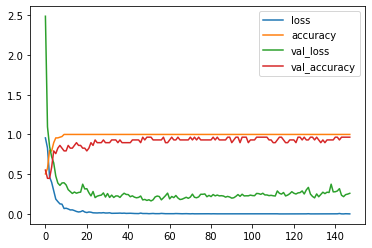

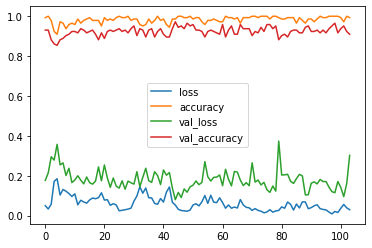

In [68]:
import pandas as pd
pd.DataFrame(history[0].history).plot()
pd.DataFrame(history[1].history).plot()

Gradcam++ class 0 layer Conv2D_1
Gradcam++ class 0 layer Conv2D_2
Gradcam++ class 1 layer Conv2D_1
Gradcam++ class 1 layer Conv2D_2


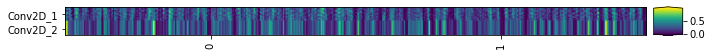

In [79]:
rel_model_name = ['Gradcam++'] #Gradcam, Gradcam++, Saliency, Scorecam
layer_name =  ['Conv2D_1','Conv2D_2'] #'conv\w*\s' ---errors, check...
relM_,tmpr_ = Attention_maps(rel_model_name,layer_name,model,
                                    X_train,y_train.astype(int),function_combination=np.prod,
                                    norm_c=False,norm_max_min=False,
                                    plot_int=False,transpose=False)

In [80]:
relM_.shape

(1, 2, 72, 22, 448)

In [66]:
model.get_layer('out_activation')
new_model = tf.keras.Model(inputs=model.input,outputs=model.get_layer('output').output)

In [63]:
yy=np.argmax(model.predict(X_valid),axis=1)


In [85]:
indx_ord = np.argsort(y_train)
new_y = y_train[indx_ord]
c=1
new_x=relM_[0,c,:,:,:,np.newaxis]*X_train[indx_ord][new_y==c]

In [86]:
new_x.shape

(72, 22, 448, 1)

In [88]:
new_model.predict(X_train[indx_ord][new_y==c])

array([[-3.4452221 ,  3.4452224 ],
       [-0.65697634,  0.6569764 ],
       [-3.3872433 ,  3.3872435 ],
       [-2.2119231 ,  2.211923  ],
       [-3.877306  ,  3.8773062 ],
       [-0.6580288 ,  0.6580287 ],
       [-3.3366811 ,  3.3366811 ],
       [-1.7189256 ,  1.7189258 ],
       [-3.0755262 ,  3.075526  ],
       [-2.053638  ,  2.053638  ],
       [-3.546307  ,  3.5463076 ],
       [-1.4340204 ,  1.4340206 ],
       [-2.4399884 ,  2.4399877 ],
       [-3.3698654 ,  3.3698652 ],
       [-2.4210782 ,  2.4210782 ],
       [-1.4264984 ,  1.4264985 ],
       [-1.3163005 ,  1.3163004 ],
       [-3.8289614 ,  3.8289618 ],
       [-4.11277   ,  4.1127696 ],
       [-3.061793  ,  3.061793  ],
       [-4.6048055 ,  4.604806  ],
       [-3.175758  ,  3.1757584 ],
       [-1.6112657 ,  1.6112658 ],
       [-2.290064  ,  2.2900643 ],
       [-2.5932078 ,  2.593208  ],
       [-3.227458  ,  3.2274575 ],
       [-3.7847767 ,  3.7847767 ],
       [-5.864941  ,  5.864941  ],
       [-2.8746843 ,

In [87]:
new_model.predict(new_x)

array([[  7.416916 ,  -7.4169164],
       [ 10.946332 , -10.946333 ],
       [  9.00318  ,  -9.003178 ],
       [  6.541586 ,  -6.5415883],
       [  6.6376796,  -6.6376815],
       [  8.208433 ,  -8.208434 ],
       [  9.581654 ,  -9.581654 ],
       [  9.062418 ,  -9.06242  ],
       [  9.822076 ,  -9.822076 ],
       [  6.0689607,  -6.06896  ],
       [  9.114246 ,  -9.114248 ],
       [  7.3134828,  -7.313483 ],
       [  8.723571 ,  -8.723573 ],
       [  5.909876 ,  -5.9098754],
       [  8.275515 ,  -8.2755165],
       [  9.349104 ,  -9.349106 ],
       [  9.752008 ,  -9.75201  ],
       [  6.9658494,  -6.965849 ],
       [ 10.412748 , -10.412748 ],
       [  7.935015 ,  -7.935017 ],
       [  8.302408 ,  -8.302408 ],
       [ 10.516855 , -10.516854 ],
       [  9.159761 ,  -9.159761 ],
       [ 10.780491 , -10.780494 ],
       [  7.361549 ,  -7.36155  ],
       [  8.529979 ,  -8.529978 ],
       [  6.6093917,  -6.6093926],
       [  6.4233437,  -6.4233437],
       [  9.641306 ,

In [64]:
yy==y_valid

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [53]:
clas=1
idx = y_train==0
xx=X_train[idx]
with tf.device('/cpu:0'):
    out_=model.predict(xx[10][np.newaxis,...])
out_

array([[0.99869424, 0.00130581]], dtype=float32)

In [25]:
relM_,tmpr_ = Attention_maps(rel_model_name,layer_name,model,
                                            X_train,y_train,function_combination=np.prod,
                                            norm_c=False,norm_max_min=False,
                                            plot_int=False,transpose=False)
        new_model = tf.keras.Model(inputs=model.input,outputs=model.get_layer('output').output)

[[...], [...], [...], [...], [...], [...], [...], [...], [...]]

In [23]:
relM_.shape

(1, 2, 72, 22, 448)

In [12]:
tmpr_.shape

(1, 4, 22, 576)

In [13]:
indx_ord = np.argsort(y_train)
relM_ravel = relM_.reshape([1,288,22,576]).squeeze()
X_train_ord=X_train[indx_ord].squeeze()

In [14]:
relM_ravel.shape,X_train_ord.shape

((288, 22, 576), (288, 22, 576))

In [15]:
new_map = relM_ravel*X_train_ord

In [17]:
new_map.shape

(288, 22, 576)

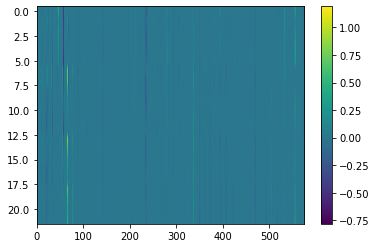

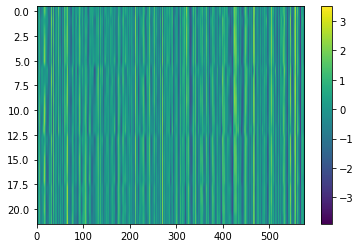

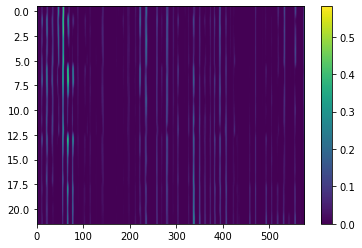

In [24]:
import matplotlib.pyplot as plt
tr=0
plt.figure()
plt.imshow(new_map[tr,:,:],aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow(X_train_ord[tr,:,:],aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow(relM_ravel[tr,:,:],aspect='auto')
plt.colorbar()

In [26]:
out_1=new_model.predict(X_train_ord[...,np.newaxis])
out_2=new_model.predict(new_map[...,np.newaxis])

In [44]:
out_1[0],out_2[0]

(array([ 3.7348657, -1.6506932, -1.5351267, -1.674215 ], dtype=float32),
 array([ -5.4884124,  22.801523 ,  23.269934 , -47.28788  ], dtype=float32))

<StemContainer object of 3 artists>

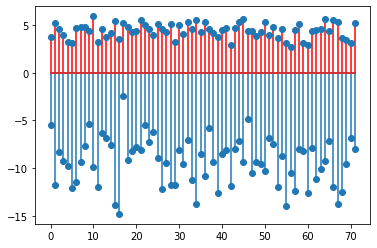

In [43]:
plt.stem(out_1[:72,0],linefmt='r')
plt.stem(out_2[:72,0])

In [84]:
subjects = np.arange(1,10)
n1 = 'result_tmpr'
n2 ='result_relM'
for sbj in subjects:
    with open(f'/home/daniel/Documents/python-gcpds.EEG_Tensorflow_models/Examples/BCI2a/tmp/confidence{sbj}_cls_2.json','r') as f:
        data=json.load(f)
    print(f'para sujeto {sbj} resulttados {n1} {np.unique(data[n1],return_counts=True)}')
    print(f'para sujeto {sbj} resulttados {n2} {np.unique(data[n2],return_counts=True)}')

para sujeto 1 resulttados result_tmpr (array([-1,  1]), array([72, 72]))
para sujeto 1 resulttados result_relM (array([-1,  1]), array([72, 72]))
para sujeto 2 resulttados result_tmpr (array([-1,  1]), array([72, 72]))
para sujeto 2 resulttados result_relM (array([-1,  0,  1]), array([72,  2, 70]))
para sujeto 3 resulttados result_tmpr (array([-1,  1]), array([72, 72]))
para sujeto 3 resulttados result_relM (array([-1,  1]), array([72, 72]))
para sujeto 4 resulttados result_tmpr (array([-1,  1]), array([72, 72]))
para sujeto 4 resulttados result_relM (array([-1,  1]), array([72, 72]))
para sujeto 5 resulttados result_tmpr (array([-1,  0,  1]), array([62, 40, 42]))
para sujeto 5 resulttados result_relM (array([-1,  0,  1]), array([55, 30, 59]))
para sujeto 6 resulttados result_tmpr (array([-1,  0,  1]), array([72,  1, 71]))
para sujeto 6 resulttados result_relM (array([-1,  1]), array([72, 72]))
para sujeto 7 resulttados result_tmpr (array([-1,  1]), array([72, 72]))
para sujeto 7 resul

In [45]:
with open('/home/daniel/Documents/python-gcpds.EEG_Tensorflow_models/Examples/BCI2a/Results_BCI2a_schirrmeister2017_ShallowConvNet2018.p','r') as handle:
            data=pickle.load(handle)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [44]:
y_all[0],y_tilde_all[0]

(array([ 3.6580381 , -1.112581  , -3.0839155 , -0.44693738], dtype=float32),
 array([  4.5897655,   7.1232233,  19.013948 , -27.87566  ], dtype=float32))

In [12]:
with tf.device('/cpu:0'):
    print(np.round(tf.nn.softmax([0.1,3,1,0.5])*100))
    print(np.round(tf.nn.softmax([1.0,23,21,5])*100))

[ 4. 79. 11.  6.]
[ 0. 88. 12.  0.]


In [ ]:
tf.nn.softmax([1,23,21,5])

In [ ]:
# get new model dropping last activation function, select input layer and output layers (
# all models are standarized to have output -2 layer and out_activation for the last layer (the activation one)
new_model = tf.keras.Model(inputs=model.input,outputs=model.get_layer('output').output)

In [ ]:
tmpr_.shape,relM_.shape

In [ ]:
cl=y_train[0]
new_model(X_train[:1]),y_train[:1],cl

In [ ]:
new_model(X_train[:1]*relM_[0,cl,0,:,:,np.newaxis])

In [ ]:
new_model(X_train[:1]*tmpr_[0,cl,:,:,np.newaxis])

In [ ]:
X_train.shape

# Exp 2: Schirmeister 2017_legal

In [ ]:
opt_args = {'lr': 0.01,'beta_1': 0.9}
optimizer = get_optimizer('Adam',opt_args)

loss = get_loss('CategoricalCrossentropy')

metrics = ['accuracy']

callbacks_names = {'early_stopping_train':'early_stopping','checkpoint_train':'checkpoint',
                'Threshold_valid':'Threshold','checkpoint_valid':'checkpoint',
                'early_stopping_valid':'early_stopping'}


Experiment = 'schirrmeister2017_legal'
model_name = 'ShallowConvNet'
Version='2018'

subjects = np.arange(1,10)
Acc = []
History = []
Subject = []
for sbj in subjects:
    print('Subject: {:d} of {:d}'.format(sbj,len(subjects)))

    X_train,y_train,X_valid,y_valid,fs = load_dataset(dataset_name="BNCI2014001", subject_id=sbj)
    fs_new = 128
    X_train = resample(X_train,int((X_train.shape[-2]/fs)*fs_new),axis=-2)    
    X_valid = resample(X_valid,int((X_valid.shape[-2]/fs)*fs_new),axis=-2)    
    model_args = {'nb_classes':4,'Chans':X_train.shape[1],'Samples':X_train.shape[2],'dropoutRate':0.5,'version':Version}
    model = get_model(model_name,model_args)


    call_args = [{'monitor':'val_accuracy','patience':100,'min_delta':0.001,'mode':'max','verbose':1,'restore_best_weights':False},
                {'filepath':'/kaggle/tmp/checkpoint_sbj_'+str(sbj),'save_format':'tf','monitor':'val_accuracy','verbose':1,'save_weights_only':True,'save_best_only':True},
                {'threshold':None},
                {'filepath':'/kaggle/tmp/checkpoint_2_sbj_'+str(sbj),'save_format':'tf','monitor':'val_accuracy','verbose':1,'save_weights_only':True,'save_best_only':True},
                {'monitor':'val_accuracy','patience':None,'min_delta':0.001,'mode':'max','verbose':1,'restore_best_weights':True}]
                
    callbacks = get_callbacks(callbacks_names,call_args)

    cv = train_model_cv(model,optimizer,loss,metrics,callbacks=callbacks)

    history = cv.fit_validation(X_train,y_train,X_val=X_valid,y_val=y_valid,batch_size=64,epochs=1000,verbose=1,val_mode=Experiment)
    acc = cv.get_accuracy()
    print('Subject accuracy: {:f}'.format(acc))
    Acc.append(acc)
    History.append(History)
    Subject.append(sbj)

    results = {}
    results['subject'] = Subject
    results['history'] = History
    results['accuracy'] = Acc

    with open('Results_BCI2a_'+Experiment+'_'+model_name+Version+'.p','wb') as handle:
        pickle.dump(results,handle)
    
    del cv,callbacks

# Exp 3: Schirmeister 2021

In [ ]:
opt_args = {'lr': 0.01,'beta_1': 0.9}
optimizer = get_optimizer('Adam',opt_args)

loss = get_loss('CategoricalCrossentropy')

metrics = ['accuracy']

callbacks_names = {'checkpoint_valid':'checkpoint',
                   'early_stopping_valid':'early_stopping'}


Experiment = 'schirrmeister2021'
model_name = 'ShallowConvNet'
Version='2018'

subjects = np.arange(1,10)
Acc = []
History = []
Subject = []
for sbj in subjects:
    print('Subject: {:d} of {:d}'.format(sbj,len(subjects)))

    X_train,y_train,X_valid,y_valid,fs = load_dataset(dataset_name="BNCI2014001", subject_id=sbj)
    fs_new = 128
    X_train = resample(X_train,int((X_train.shape[-2]/fs)*fs_new),axis=-2)    
    X_valid = resample(X_valid,int((X_valid.shape[-2]/fs)*fs_new),axis=-2)    
    model_args = {'nb_classes':4,'Chans':X_train.shape[1],'Samples':X_train.shape[2],'dropoutRate':0.5,'version':Version}
    model = get_model(model_name,model_args)
    
    

    call_args = [
            {'filepath':'/kaggle/tmp/checkpoint_'+str(sbj),
            'save_format':'tf',
            'monitor':'val_accuracy',
            'verbose':1,
            'save_weights_only':True,
            'save_best_only':True},
            {'monitor':'val_accuracy',
            'patience':100,
            'min_delta':0.001,
            'mode':'max',
            'verbose':1,
            'restore_best_weights':True}]
                
    callbacks = get_callbacks(callbacks_names,call_args)

    cv = train_model_cv(model,optimizer,loss,metrics,callbacks=callbacks)

    history = cv.fit_validation(X_train,y_train,X_val=X_valid,y_val=y_valid,batch_size=64,epochs=1000,verbose=1,val_mode=Experiment)
    acc = cv.get_accuracy()
    print('Subject accuracy: {:f}'.format(acc))
    Acc.append(acc)
    History.append(History)
    Subject.append(sbj)

    results = {}
    results['subject'] = Subject
    results['history'] = History
    results['accuracy'] = Acc

    with open('Results_BCI2a_'+Experiment+'_'+model_name+Version+'.p','wb') as handle:
        pickle.dump(results,handle)
    
    del cv,callbacks

# Exp 4: 4-fold CV


In [ ]:
opt_args = {'lr': 0.01,'beta_1': 0.9}
optimizer = get_optimizer('Adam',opt_args)

loss = get_loss('CategoricalCrossentropy')

metrics = ['accuracy']

callbacks_names = {'checkpoint_train1':'checkpoint','checkpoint_train2':'checkpoint','checkpoint_train3':'checkpoint','checkpoint_train4':'checkpoint'}


Experiment = 'lawhern2018'
model_name = 'ShallowConvNet'
Version='2018'

fs_new = 128


subjects = np.arange(1,10)
Acc = []
History = []
Subject = []
for sbj in subjects:
    print('Subject: {:d} of {:d}'.format(sbj,len(subjects)))

    X_train,y_train,X_valid,y_valid,fs = load_dataset(dataset_name="BNCI2014001", subject_id=sbj)
    fs_new = 128
    X_train = resample(X_train,int((X_train.shape[-2]/fs)*fs_new),axis=-2)    
    X_valid = resample(X_valid,int((X_valid.shape[-2]/fs)*fs_new),axis=-2)    
    model_args = {'nb_classes':4,'Chans':X_train.shape[1],'Samples':X_train.shape[2],'dropoutRate':0.5,'version':Version}
    model = get_model(model_name,model_args)

    call_args = [
            
            {'filepath':'/kaggle/tmp/checkpoint1_'+str(sbj),
            'save_format':'tf',
            'monitor':'val_accuracy',
            'verbose':1,
            'save_weights_only':True,
            'save_best_only':True},
             {'filepath':'/kaggle/tmp/checkpoint2_'+str(sbj),
            'save_format':'tf',
            'monitor':'val_accuracy',
            'verbose':1,
            'save_weights_only':True,
            'save_best_only':True},
             {'filepath':'/kaggle/tmp/checkpoint3_'+str(sbj),
            'save_format':'tf',
            'monitor':'val_accuracy',
            'verbose':1,
            'save_weights_only':True,
            'save_best_only':True},
             {'filepath':'/kaggle/tmp/checkpoint4_'+str(sbj),
            'save_format':'tf',
            'monitor':'val_accuracy',
            'verbose':1,
            'save_weights_only':True,
            'save_best_only':True}]
                
    callbacks = get_callbacks(callbacks_names,call_args)

    cv = train_model_cv(model,optimizer,loss,metrics,callbacks=callbacks)

    history = cv.fit_validation(X_train,y_train,X_val=X_valid,y_val=y_valid,batch_size=64,epochs=1000,verbose=1,val_mode=Experiment)
    acc = cv.get_accuracy()
    print('Subject accuracy: {:f}'.format(acc))
    Acc.append(acc)
    History.append(History)
    Subject.append(sbj)

    results = {}
    results['subject'] = Subject
    results['history'] = History
    results['accuracy'] = Acc

    with open('Results_BCI2a_'+Experiment+'_'+model_name+Version+'.p','wb') as handle:
        pickle.dump(results,handle)
    
    del cv,callbacks